# Description of the breast lesion deep learning project

## Motivation and notes

## Publications data sources

Al-Dhabyani, W., Gomaa, M., Khaled, H., & Fahmy, A. (2019). Dataset of breast ultrasound images. Data in brief, 28, 104863. https://doi.org/10.1016/j.dib.2019.104863

Pawłowska, A., Ćwierz-Pieńkowska, A., Domalik, A., Jaguś, D., Kasprzak, P., Matkowski, R., Fura, Ł., Nowicki, A., & Zolek, N. (2024). A Curated Benchmark Dataset for Ultrasound Based Breast Lesion Analysis (Breast-Lesions-USG) (Version 1) [dataset]. The Cancer Imaging Archive. https://doi.org/10.7937/9WKK-Q141

**the following data is not included yet**

A. Abbasian Ardakani, A. Mohammadi, M. Mirza-Aghazadeh-Attari, U.R. Acharya, An open-access breast lesion ultrasound image database‏: Applicable in artificial intelligence studies, Computers in Biology and Medicine, 152 (2023) 106438. https://doi.org/10.1016/j.compbiomed.2022.106438



# Data exploration 

## Plotting example images

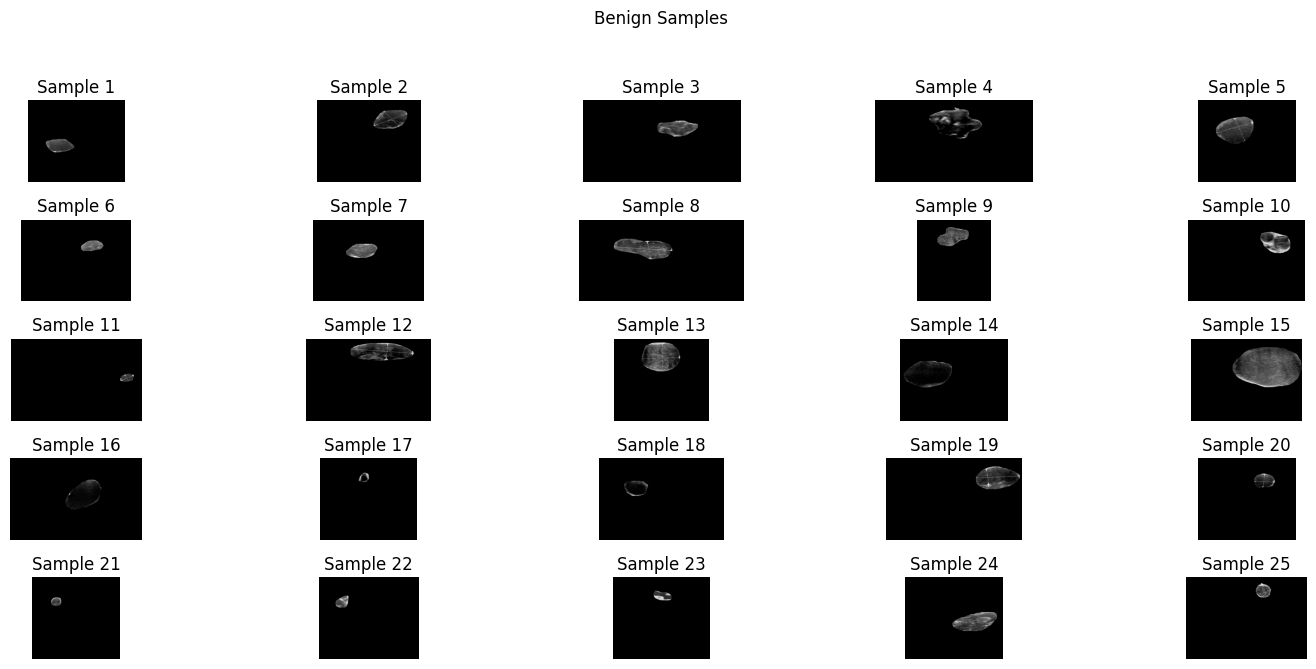

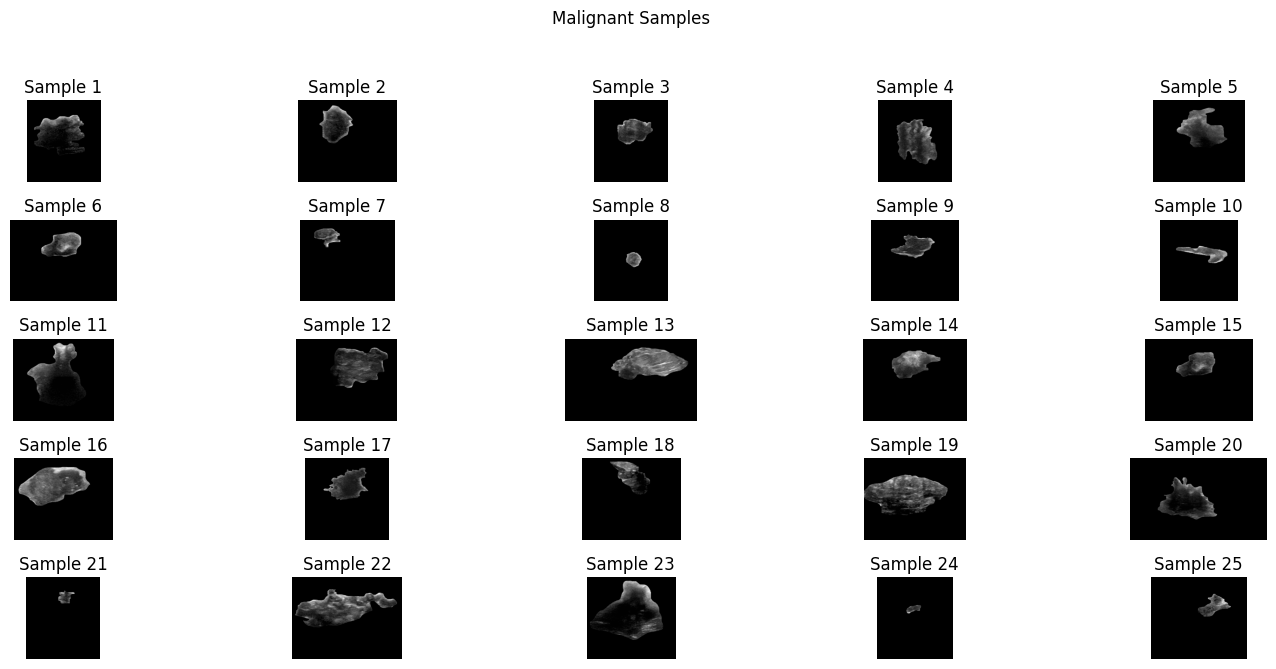

In [7]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def plot_class_samples(base_path, class_name, num_samples=10):
    plt.figure(figsize=(15, 7))
    class_folder = os.path.join(base_path, class_name)
    image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.png')]

    for i in range(min(num_samples, len(image_files))):
        img_path = image_files[i]
        img = Image.open(img_path).convert('L')  # Load in grayscale
        ax = plt.subplot(5, 5, i + 1)  # Adjust subplot grid for 10 images: 2 rows and 5 columns
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Sample {i + 1}")
        ax.axis('off')

    plt.suptitle(f"{class_name.capitalize()} Samples")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

base_path = '/kaggle/input/breast-lesion-dataset/Ordered_images'

plot_class_samples(base_path, 'benign', num_samples=25)

plot_class_samples(base_path, 'malignant', num_samples=25)

In [8]:
import os
import pandas as pd

def create_classification_df(base_path):
    categories = ['benign', 'malignant']
    data = []

    for category in categories:
        class_folder = os.path.join(base_path, category)
        # List files in the directory
        image_files = [f for f in os.listdir(class_folder) if f.endswith('.png')]

        # Create a list of dictionaries containing the filename and classification
        data.extend([{'filename': os.path.join(class_folder, f), 'classification': category} for f in image_files])

    df = pd.DataFrame(data)
    return df

base_path = '/kaggle/input/breast-lesion-dataset/Ordered_images'
df = create_classification_df(base_path)

                                              filename classification
0    /kaggle/input/breast-lesion-dataset/Ordered_im...         benign
1    /kaggle/input/breast-lesion-dataset/Ordered_im...         benign
2    /kaggle/input/breast-lesion-dataset/Ordered_im...         benign
3    /kaggle/input/breast-lesion-dataset/Ordered_im...         benign
4    /kaggle/input/breast-lesion-dataset/Ordered_im...         benign
..                                                 ...            ...
894  /kaggle/input/breast-lesion-dataset/Ordered_im...      malignant
895  /kaggle/input/breast-lesion-dataset/Ordered_im...      malignant
896  /kaggle/input/breast-lesion-dataset/Ordered_im...      malignant
897  /kaggle/input/breast-lesion-dataset/Ordered_im...      malignant
898  /kaggle/input/breast-lesion-dataset/Ordered_im...      malignant

[899 rows x 2 columns]


## Is there a class imbalance? 

In [9]:
df['classification'].value_counts()

classification
benign       591
malignant    308
Name: count, dtype: int64

# Model building

## Loading data with keras.preprocessing function (tip from Vlad)

In [10]:
import tensorflow as tf

# parameters for the dataset generation
batch_size = 32
img_height = 224  # what should the input size be? #224
img_width = 224   # ?

# Create training dataset from directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    labels='inferred',
    label_mode='int',   # Labels are returned as integers
    class_names=['benign', 'malignant'], # class names
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),  # resize images to the specified size
    shuffle=True,        # shuffles the data
    seed=123,            # seed for shuffling and transformations
    validation_split=0.2,  # image proportion for validation
    subset='training',
)

# Crreating validation set
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    labels='inferred',
    label_mode='int',
    class_names=['benign', 'malignant'],
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 899 files belonging to 2 classes.
Using 720 files for training.
Found 899 files belonging to 2 classes.
Using 179 files for validation.


## Data preprocessing and augmentation 

## Edge detection: is it true that benign lesions are rather round and malignant ones are rather irregularly shaped? 

## Inspect Preprocessed Images?

## Baseline model

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

img_height = 224
img_width = 224

def make_model(input_shape):
    model = models.Sequential([
        layers.experimental.preprocessing.Rescaling(1./255, input_shape=input_shape),

        # Data augmentation layers
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),  # Dropout layer added

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),  # Dropout layer added

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),  # Dropout layer added

        # Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Increased dropout for dense layer
        layers.Dense(2, activation='softmax')
    ])
    return model

# Create the model
model = make_model((img_height, img_width, 1))  # '1' for grayscale

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Training the model
history = model.fit(
    dataset,
    validation_data=validation_dataset,
    epochs=10
)


Model: "sequential_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 rescaling_2 (Rescaling)     (None, 180, 180, 1)       0         

                                                                 

 random_flip_1 (RandomFlip)  (None, 180, 180, 1)       0         

                                                                 

 random_rotation_1 (RandomRo  (None, 180, 180, 1)      0         

 tation)                                                         

                                                                 

 random_zoom_1 (RandomZoom)  (None, 180, 180, 1)       0         

                                                                 

 conv2d_6 (Conv2D)           (None, 178, 178, 32)      320       

                                                                 

 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         

 2D)                                  

In [11]:
# VGG16 version
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

img_height = 224
img_width = 224

def make_model(input_shape):
    # Load VGG16 without the top layer (fully connected layers)
    base_model = VGG16(include_top=False, input_shape=(input_shape[0], input_shape[1], 3), weights='imagenet')

    # Freeze the layers of the VGG16 model to prevent updating weights during training
    for layer in base_model.layers:
        layer.trainable = False

    model = models.Sequential([
        # Convert grayscale images to RGB
        layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x), input_shape=(img_height, img_width, 1)),

        base_model,
        # Additional layers on top of VGG16
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create the model
model = make_model((img_height, img_width, 1))  # Keep '1' for grayscale, and convert to '3' in the Lambda layer

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Training the model
history = model.fit(
    dataset,
    epochs=10,
    validation_data=validation_dataset
)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10


2024-05-07 08:56:24.620514: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-05-07 08:56:24.620572: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-05-07 08:56:24.620589: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-05-07 08:56:24.620607: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-05-07 08:56:24.620631: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-05-07 08:56:24.620642: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-05-07 08:56:24.620653: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-05-07 08:56:24.620663: E external/local_xla/xla/se

 2/23 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5078 - loss: 9.7469 

I0000 00:00:1715072200.762001     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7226 - loss: 11.6621

2024-05-07 08:56:43.326498: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.89842, expected 3.37692
2024-05-07 08:56:43.326555: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 3.13412, expected 2.61262
2024-05-07 08:56:43.326564: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 13: 3.08377, expected 2.56227
2024-05-07 08:56:43.326572: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 14: 4.1021, expected 3.5806
2024-05-07 08:56:43.326580: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 29: 3.76539, expected 3.24388
2024-05-07 08:56:43.326587: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 30: 4.19841, expected 3.6769
2024-05-07 08:56:43.326595: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 63: 3.88366, expected 3.36216
2024-05-07 08:56:43.326602: E external/local_xla/xla

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7261 - loss: 11.5789

2024-05-07 08:56:54.838182: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.83445, expected 3.08393
2024-05-07 08:56:54.838253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.81387, expected 5.06335
2024-05-07 08:56:54.838262: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.65478, expected 4.90426
2024-05-07 08:56:54.838270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.2384, expected 5.48788
2024-05-07 08:56:54.838277: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.85899, expected 5.10847
2024-05-07 08:56:54.838285: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.234, expected 4.48348
2024-05-07 08:56:54.838292: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.17387, expected 4.42335
2024-05-07 08:56:54.838300: E external/local_xla/xla/servi

23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.7293 - loss: 11.5027 - val_accuracy: 0.8212 - val_loss: 33011.2734
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9193 - loss: 2.5537 - val_accuracy: 0.8156 - val_loss: 20570.3262
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9198 - loss: 0.7459 - val_accuracy: 0.8492 - val_loss: 34601.9766
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9091 - loss: 0.4806 - val_accuracy: 0.8380 - val_loss: 23391.5664
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9388 - loss: 0.3711 - val_accuracy: 0.8324 - val_loss: 20096.3711
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9409 - loss: 0.2055 - val_accuracy: 0.8101 - val_loss: 25755.5859
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9389 - loss: 0.1421 - val_accuracy: 0.8492 - val_loss: 12789.9512
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9456 - loss: 0.1603 - val_acc

In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

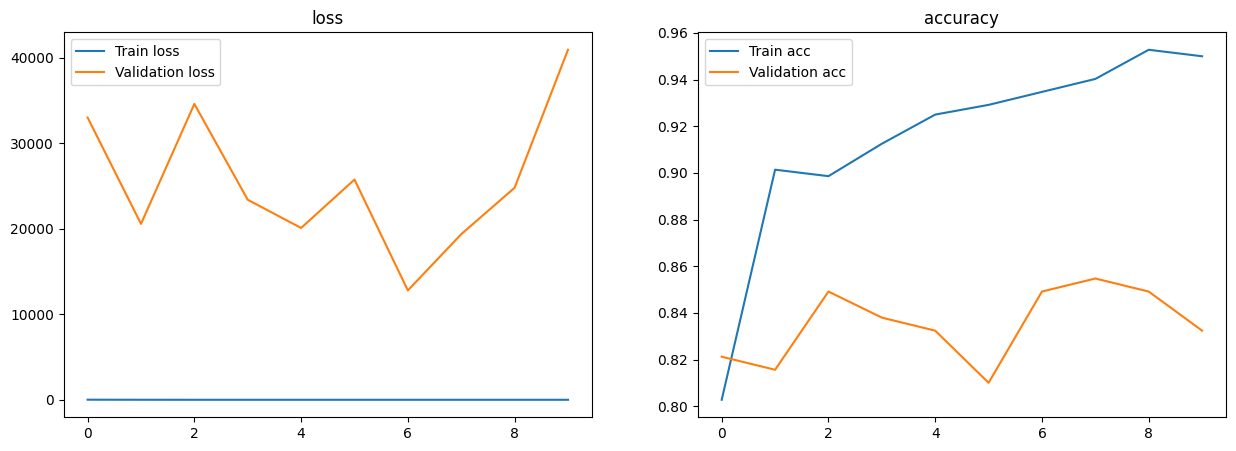

In [13]:
plot_history(history)